In [2]:
%run 'Functions.ipynb'

In [2]:
class Granularity(Enum):
    second = timedelta(seconds=1)
    minute = timedelta(minutes=1)
    hour = timedelta(hours=1)
    day = timedelta(days=1)
    week = timedelta(weeks=1)
    month = timedelta(hours=730)
    year = timedelta(hours=8760)

In [3]:
def parse_iso_date(str):
    return datetime.strptime(str, '%Y-%m-%dT%H:%M:%S.%fZ')

In [4]:
date = '2015-01-31T00:00:00.00Z'
granularity = 'day'
foreground_window = 10
background_window = 365
min_freq_threshold = 5
smoothing_window = 7
num_cluster = 3
analysis_field = 'abstracts.value'
date_field = 'earliest_date'
index = 'hep-analysis'
doc_type = 'hep'

In [5]:
reference_date = parse_iso_date(date)
gran = Granularity[granularity]
foreground_start = reference_date - foreground_window * gran.value
background_start = reference_date - background_window * gran.value

In [6]:
def interval_ids(index, start, end, date_field, analysis_field):
    q = Search(index=index) \
        .fields(['']) \
        .filter('exists', field=analysis_field) \
        .filter('range', **{date_field: {'gt': start, 'lte': end}})
    return [elem.meta.id for elem in q.scan()]

In [7]:
def term_vectors(index, doc_type, ids, analysis_field, chunk=100):
    res = []
    for pos in range(0, len(ids), chunk):
        q = client.mtermvectors(
            index=index,
            doc_type=doc_type,
            ids=ids[pos:pos + chunk],
            fields=[analysis_field],
            field_statistics=False,
            term_statistics=True,
            offsets=False,
            payloads=False,
            positions=False,
            realtime=True
        )
        for doc in q['docs']:
            if analysis_field in doc['term_vectors']:
                res.append(doc['term_vectors'][analysis_field]['terms'])
    assert len(ids) == len(res)
    return res

In [8]:
def fold_vectors(vectors):
    words = {}
    for vec in vectors:
        for word, freqs in vec.items():
            if word in words:
                words[word]['term_freq'] += freqs['term_freq']
                words[word]['doc_freq'] += 1
            else:
                words[word] = {
                    'term_total': freqs['ttf'], # estimate
                    'doc_total': freqs['doc_freq'], # estimate
                    'term_freq': freqs['term_freq'],
                    'doc_freq': 1,
                }
    return words

In [9]:
def sorting_freq_threshold(terms, min_freq_threshold):
    filtered = [(term, stats) for term, stats in terms.items() if stats['doc_freq'] >= min_freq_threshold]
    return sorted(filtered, key=lambda elem: -elem[1]['doc_freq'])

In [10]:
def unzip(data):
    if not len(data):
        return [], []
    x, y = zip(*[(parse_iso_date(elem.key_as_string), elem.doc_count) for elem in data])
    return np.array(x), np.array(y)

In [11]:
def date_histogram(index, start, end, granularity, date_field, analysis_field):
    all_terms = Search(index=index)[0:0] \
        .filter('range', **{date_field: {'gt': start, 'lte': end}})
    all_terms.aggs.bucket(
        'hist', 
        'date_histogram', 
        field=date_field, 
        interval=granularity.name,
        format='date_optional_time'
    )
    return unzip(all_terms.execute().aggregations.hist.buckets)

In [12]:
def term_date_histogram(index, term, start, end, granularity, date_field, analysis_field):
    all_terms = Search(index=index)[0:0] \
        .query('match_phrase', **{analysis_field: term}) \
        .filter('range', **{date_field: {'gt': start, 'lte': end}})
    all_terms.aggs.bucket(
        'hist', 
        'date_histogram', 
        field=date_field, 
        interval=granularity.name,
        format='date_optional_time'
    )
    return unzip(all_terms.execute().aggregations.hist.buckets)

In [13]:
def safe_divide(numerator, denominator):
    with np.errstate(divide='ignore', invalid='ignore'):
        res = np.divide(numerator, denominator)
        res[~ np.isfinite(res)] = 0
        return res

In [14]:
def normalize_hist(hist, hist_reference):
    
    x, y = hist
    x_ref, y_ref = hist_reference
    
    before_count = np.where(x_ref == x[0])[0][0]
    after_count = len(x_ref) - np.where(x_ref == x[-1])[0][0] - 1
    y = np.append(np.zeros(before_count), np.append(y, np.zeros(after_count)))
    
    return x_ref, safe_divide(y, y_ref)

In [15]:
def transform_score(hist, foreground_start, smoothing_window):
    
    x, y = hist
    
    window = np.ones(smoothing_window)
    y = sp.signal.convolve(y, window, mode='valid')
    
    invalid = len(x) - len(y)
    invalid_before = invalid // 2
    invalid_after = invalid_before + invalid % 2
    x = x[invalid_before:-invalid_after]
    assert len(x) == len(y)
    
    foreground_index = np.where(x == foreground_start)[0][0]
    x_fg = x[foreground_index - invalid_after:]
    y_fg = y[foreground_index - invalid_after:]
    
    zscore = (y_fg - np.mean(y)) / np.std(y)
    #buckets = np.digitize(zscore, np.linspace(-5, 5, 10))
    
    return x_fg, zscore

In [16]:
ids = interval_ids(index, foreground_start, reference_date, date_field, analysis_field)
vectors = term_vectors(index, doc_type, ids, analysis_field)
raw_terms = fold_vectors(vectors)
terms = sorting_freq_threshold(raw_terms, min_freq_threshold)

In [34]:
len(terms)

2576

In [17]:
hist_reference = date_histogram(index, background_start, reference_date, gran, date_field, analysis_field)

In [18]:
hists = []
for term, stats in terms:
    
    hist = term_date_histogram(index, term, background_start, reference_date, gran, date_field, analysis_field)
    
    if len(hist[1]) >= smoothing_window:
        norm_hist = normalize_hist(hist, hist_reference)
        hists.append(norm_hist)

In [19]:
scores = []
for hist in hists:
    score = transform_score(hist, foreground_start, smoothing_window)
    scores.append(score)

In [20]:
from sklearn.cluster import KMeans

In [21]:
km = KMeans(n_clusters=num_cluster)
pred = km.fit_predict([elem[1] for elem in scores])
clusters = km.cluster_centers_

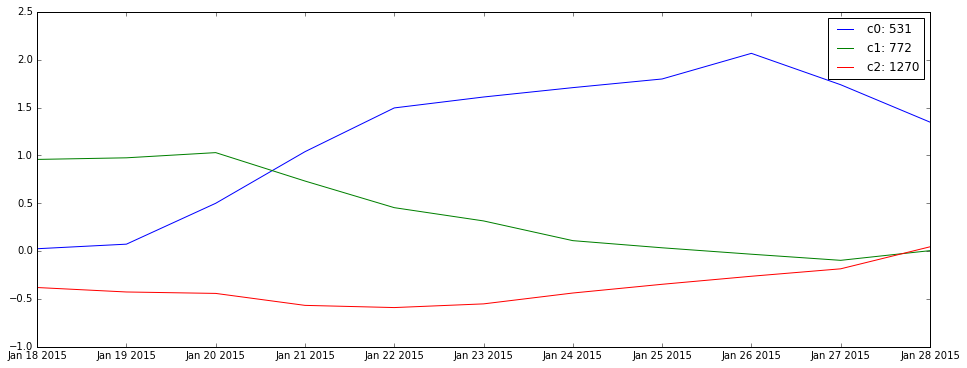

In [22]:
for i, center in enumerate(clusters):
    plt.plot(scores[0][0], center, label='c%d: %d' % (i, np.count_nonzero(pred == i)))
plt.legend()

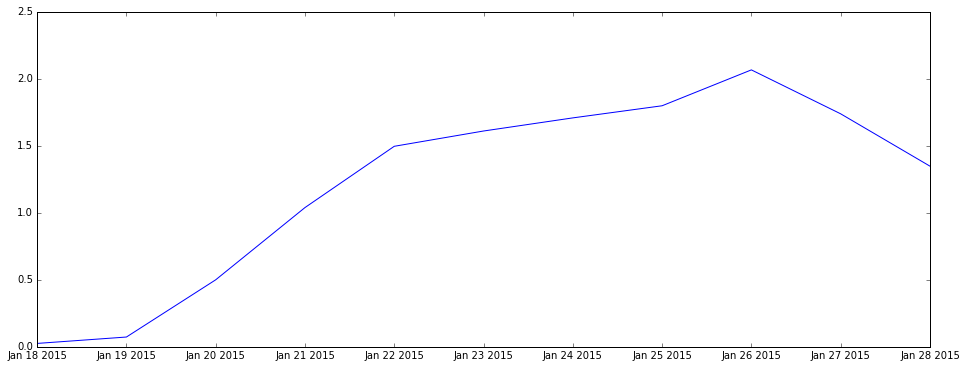

In [23]:
highest_feature = np.argmax(np.max(np.gradient(clusters, axis=1), axis=1))
plt.plot(scores[0][0], clusters[highest_feature])

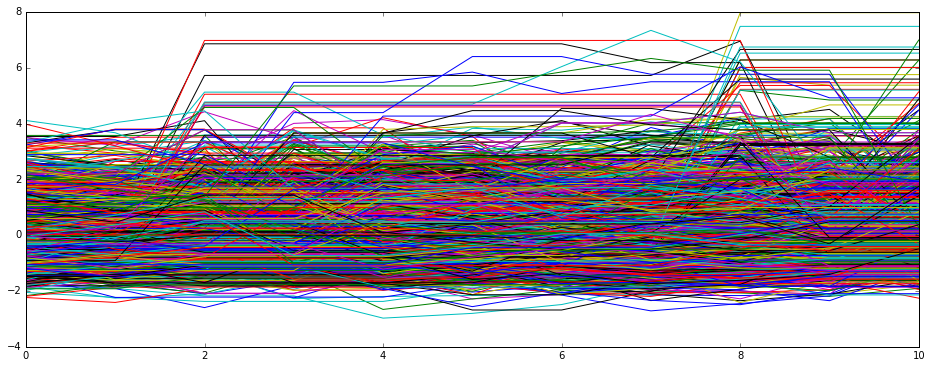

In [24]:
for s in scores:
    plt.plot(s[1])

In [25]:
res = []
for i, cluster in enumerate(pred):
    
    if cluster == highest_feature:
        stats = terms[i][1]
        print('%s %f' % (terms[i][0], stats['doc_freq'] / stats['doc_total']))
        res.append([terms[i], stats['doc_freq'] / stats['doc_total']])


study 0.047459
obtain 0.051131
system 0.055537
discuss 0.055405
function 0.049804
investigate 0.055242
paper 0.049145
describe 0.047619
experimental 0.061307
low 0.042308
will 0.050885
gauge 0.057494
due 0.048342
quark 0.059316
effects 0.048027
physical 0.065104
mechanism 0.064423
temperature 0.046239
magnetic 0.048327
point 0.041748
important 0.050725
qcd 0.070470
mev 0.077510
given 0.051483
develop 0.046473
fermion 0.073394
break 0.062718
zero 0.059955
observable 0.059172
many 0.052743
higg 0.050989
target 0.071975
fusion 0.186441
main 0.050171
description 0.054224
meson 0.068800
part 0.053846
features 0.054124
symmetrical 0.062112
review 0.048872
self 0.051491
detection 0.038815
carry 0.060510
magnetic field 0.046972
finally 0.037794
apply 0.048240
beyond 0.051282
thermal 0.040509
critical 0.048023
ion 0.046218
need 0.048601
fluctuate 0.055556
assume 0.035754
therefore 0.043972
spacetime 0.044993
full 0.038605
systematic 0.035503
early 0.029928
special 0.058116
curve 0.044140
centra

In [26]:
newest_res = sorted(res, key=lambda x: -x[1])

In [27]:
[e[0][0] for e in newest_res]

['crc',
 'complete fusion',
 'entrance channel',
 'evaporate residue',
 'fusion cross section',
 'entrance',
 'leading twist',
 'optical model',
 'gauge action',
 'sub barrier',
 'fusion reaction',
 'dependent parton distribution',
 'may produce',
 'basically',
 'barrel',
 'reaction cross',
 'generalize parton',
 'can well',
 'analyze use',
 'bethe ansatz',
 'fusion',
 'cmo',
 'repulsion',
 'inclusive deep',
 'system find',
 'breakup',
 'higg model',
 'electron scatter',
 'detector system',
 'jefferson lab',
 'can derive',
 'qcd sum',
 'qcd sum rule',
 'equation obtain',
 'conflict',
 'mass parameter',
 'density dependent',
 'chaos',
 'excited state',
 'transverse momentum dependent',
 'imaginary',
 'discrete symmetry',
 'energy dependence',
 'start point',
 'couple channel',
 'wheel',
 'foundation',
 'cc',
 'general relativity gr',
 'particle identification',
 'dissipation',
 'torque',
 'isobar',
 'external magnetic field',
 'external magnetic',
 'textit',
 'strange quark',
 'noncommu

In [28]:
from sklearn.decomposition import PCA

In [29]:
p = PCA(n_components=2).fit_transform([elem[1] for elem in scores])

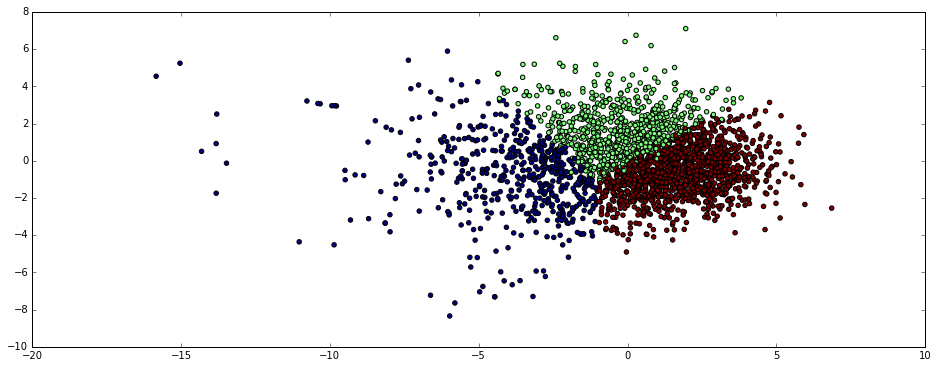

In [30]:
plt.scatter(p[:, 0], p[:, 1], c=pred)

In [31]:
from sklearn.manifold import TSNE

In [32]:
t = TSNE(n_components=2).fit_transform([elem[1] for elem in scores])

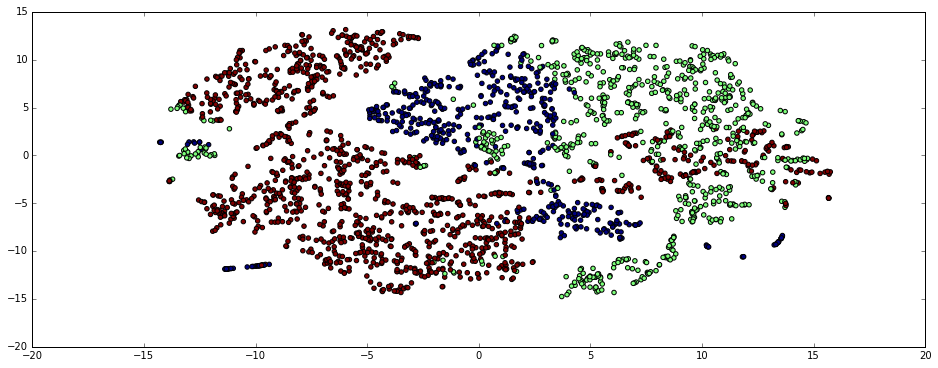

In [33]:
plt.scatter(t[:, 0], t[:, 1], c=pred)

In [6]:
import json

In [11]:
Elasticsearch().transport.hosts

[{}]